In [1]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE

In [2]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

def visualize_img(X_2d, label, savepath):
    import numpy as np
    from matplotlib import pyplot as plt
    
    target_ids = range(len(np.unique(label)))
    fig = plt.figure()
    colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'tab:brown', 'orange', 'purple'
    for i, c in zip(target_ids, colors):
        plt.scatter(X_2d[label == i, 0], X_2d[label == i, 1], c=c, label=i, alpha=0.2)
    plt.legend()
    plt.show()
    fig.savefig(savepath, dpi = 150)

In [3]:
imgs, labels = load_mnist('')

In [4]:
import random
r_size = 30000
sample_idx = random.sample(range(imgs.shape[0]),r_size)
sampled_imgs = imgs[sample_idx]
sampled_labels = labels[sample_idx]

# 1. PCA projection

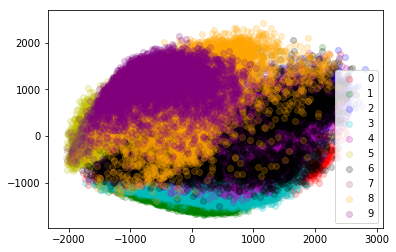

In [34]:
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(imgs)
visualize_img(pca_transformed, labels, 'PCA_projection.png')

# 2. ISOMAP

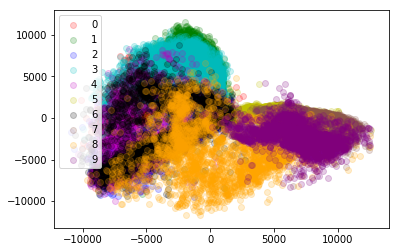

In [8]:
isomap = Isomap(n_neighbors=3)
isomap_transformed = isomap.fit_transform(sampled_imgs)
visualize_img(isomap_transformed, sampled_labels, 'isomap.png')

# 3. t-SNE on the raw image

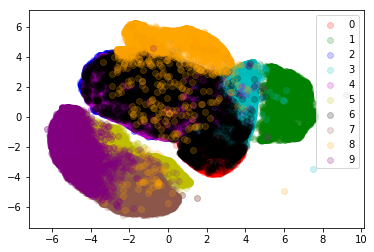

In [13]:
tsne = TSNE(n_iter=300)
tsne_transformed = tsne.fit_transform(imgs)
visualize_img(tsne_transformed, labels, 'tsne-2.png')

# 4. t-SNE on features extracted

In [5]:
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from tqdm import tqdm

In [6]:
import torch
import torch.nn as nn

class FashionSimpleNet(nn.Module):

    """ Simple network"""

    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1,32, kernel_size=3, padding=1), # 28
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 14

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) # 7
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 64 * 7 * 7)
        x = self.classifier(x)
        return x

In [9]:
m_path = 'fashion-mnist/saved-models/FashionSimpleNet-run-129.pth.tar'
model = FashionSimpleNet()
model.load_state_dict(torch.load(m_path)['state_dict'])
new_classifier = nn.Sequential(*list(model.classifier.children())[:-1])
model.classifier = new_classifier

AttributeError: module 'torch._C' has no attribute '_cuda_getDevice'

In [7]:
train_transforms = transforms.Compose([
                        # transforms.RandomHorizontalFlip(),
                        # utils.RandomRotation(),
                        # utils.RandomTranslation(),
                        # utils.RandomVerticalFlip(),
                        transforms.ToTensor()
                        # transforms.Normalize((0.1307,), (0.3081,))
                        ]
                        )
trainset = FashionMNIST('fashion-mnist/data/', train=True, download=True, transform=train_transforms)
train_loader = DataLoader(trainset, batch_size=64)

In [8]:
def extractFeatures(net, loader):
    net.eval()

    size = loader.dataset.train_data.shape[0]
    batch_size = loader.batch_size
    num_batches = size // batch_size
    num_batches = num_batches if loader.drop_last else num_batches + 1
    
    features = []
    for i, (X,y) in tqdm(enumerate(loader), desc='validation', total=num_batches):
        X, y = Variable(X, volatile=True), Variable(y)
        features += list(net(X))
    return np.array([f.data.numpy() for f in features])

In [59]:
img_features = extractFeatures(model, train_loader)

validation: 100%|██████████| 938/938 [00:23<00:00, 39.86it/s]


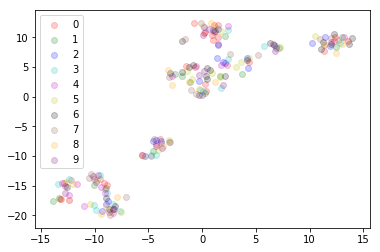

In [61]:
feature_tsne_transformed = tsne.fit_transform(sampled_img_features)
visualize_img(feature_tsne_transformed, sampled_img_labels, 'feature_tsne.png')

In [60]:
r_size = 200
sample_idx = random.sample(range(imgs.shape[0]),r_size)
sampled_img_features = img_features[sample_idx]
sampled_img_labels = labels[sample_idx]